In [1]:
# Set this variable! If you're running in Google colab, set it to true.
is_colab = False

In [2]:
# Imports
if is_colab:
    from google.colab import drive
    from google.colab import drive
    drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from scipy import stats
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load the data
if is_colab:
    df = pd.read_csv('/content/drive/My Drive/WallStreetBetsClassifier/processed_larger.csv', names=["Time", "Ticker", "Body", "Author", "Score", "Ups", "Downs", "Controversiality", "Gilded", "Current_Price", "1D", "2D", "3D", "5D", "10D"])
else:
    df = pd.read_csv('processed_larger.csv', names=["Time", "Ticker", "Body", "Author", "Score", "Ups", "Downs", "Controversiality", "Gilded", "Current_Price", "1D", "2D", "3D", "5D", "10D"])

In [4]:
def price_change_trans(pct_change):
    if pct_change < -0.05: return 0
    elif pct_change < -0.01 and pct_change > -0.05: return 1
    elif pct_change < 0.01 and pct_change > -0.01: return 2
    elif pct_change < 0.05 and pct_change > 0.01: return 3
    else: return 4


# Add diffs in price columns, % changed and categorical price changes.
def add_price_cols(df):

    price_cols = ["1D", "2D", "3D", "5D", "10D"]

    for price in price_cols:
        percent_col = pd.DataFrame(df["Current_Price"] / df[price].fillna(0) - 1.00,  columns = [price + "_pct_change"])
        df = df.join(percent_col)

        # Categorical price change
        # "Down-, Down, Neutral, Up, Up+" = [<-5%, -1% - -5%, -1% - +1%, +1% - +5%, +5%+]
        price_change_df = pd.DataFrame(list(df[price + "_pct_change"].map(price_change_trans)), columns = [price + "_cat"])
        df = df.join(price_change_df)

    return df

df = add_price_cols(df)

14192
31981
29573
25092
13944


In [5]:
# Make a train, val, test split for our data
def train_val_test_split(df, train_frac=0.8, val_frac=0.1):

    df.sort_values('Time')
    num_rows = len(df)
    train = df[0:int(train_frac * num_rows)]
    val = df[int(train_frac * num_rows):int(train_frac * num_rows)+int(val_frac * num_rows)]
    test = df[int(train_frac * num_rows)+int(val_frac * num_rows):]
    return train, val, test

train_df, val_df, test_df = train_val_test_split(df)

In [6]:
# Experiment class
class Experiment:
    def __init__(self, train_df, val_df, model, vectorizer, y_col_name="3D"):
        """
        vectorizer: accepts string and returns numpy array representing embedding for string
        Input: "I think SPY is going up"
        Output: np.array([343, 5674, 345, 3654, 23, 6546, 23434, 4345 234, 345]) 
        """
        self.train_df = train_df
        self.val_df = val_df
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = None
        self.X_val = None
        self.y_train = None 
        self.y_val = None
        self.y_col_name = y_col_name
        
        self.populate_x_y()

    def vectorize_string(self, body):
        return self.vectorizer(body)

    def populate_x_y(self):
        # TODO: Our X could be more than just the body if we want to add more features, e.g. author, score
        # Turn into lists for use in sklearn.
        self.X_train = list(map(self.vectorizer, list(self.train_df["Body"])))
        self.X_val = list(map(self.vectorizer, list(self.val_df["Body"])))
        self.y_train = list(self.train_df[self.y_col_name])
        self.y_val = list(self.val_df[self.y_col_name])

    def fit(self, X=None, y=None):
        if X is None or y is None:
            X = self.X_train
            y = self.y_train
        self.model.fit(X, y)

    def predict(self, X_test=None):
        if X_test is None:
            X_test = self.X_val
        return self.model.predict(X_test)


In [7]:
# Test the Experiment class
def dummy_vectorizer(body):
    return np.array([54, 54,34, 234 ,345, 345])

In [8]:
# This is from CS224U HW2
def glove2dict(src_filename):
    """GloVe Reader.

    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.

    Returns
    -------
    dict
        Mapping words to their GloVe vectors as `np.array`.

    """
    # This distribution has some words with spaces, so we have to
    # assume its dimensionality and parse out the lines specially:
    if '840B.300d' in src_filename:
        line_parser = lambda line: line.rsplit(" ", 300)
    else:
        line_parser = lambda line: line.strip().split()
    data = {}
    with open(src_filename, encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line_parser(line)
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

In [9]:
# Create a glove vectorizer from 300 dimensional Glove.6B
if is_colab:
    glove_dict = glove2dict("/content/drive/My Drive/WallStreetBetsClassifier/glove.6B.300d.txt")
else:
    glove_dict = glove2dict("glove.6B.300d.txt")

def glove_vectorizer(body):
  unk_vec = np.zeros(300)
  result = np.zeros(300)
  body_lower = body.lower()
  body_split = body_lower.split()
  for word in body_split:
    vec_for_word = glove_dict.get(word)
    if vec_for_word is None:
      vec_for_word = unk_vec
    result += vec_for_word
  return result

### **"Random" Guess**

In [33]:
# Use a normal distribution for our price changes.
np.random.seed(224)
norm = stats.norm(1.938, 1.223)

# Generate numbers according to this normal distribution.
y_pred_raw = norm.rvs(size = len(val_df))

y_pred = []
for val in y_pred_raw:
    if val < 0:
        y_pred.append(0)
    elif val > 4:
        y_pred.append(4)
    else:
        y_pred.append(int(round(val)))

# Create an experiment to do a random guess according to a normal distributions.
experiment_random = Experiment(train_df, val_df, None, lambda x: x, y_col_name="3D_cat")
y_true = experiment_random.y_val

print(metrics.accuracy_score(y_pred, y_true))


0.22815407355882097


### **Linear SVM**

In [10]:
#from sklearn.svm import LinearSVC

# Train a model using the 3-day price change category as the predicted value.
#experiment_svm = Experiment(train_df, val_df, LinearSVC(random_state=0, tol=1e-5, verbose=1, max_iter=10000), glove_vectorizer, y_col_name="3D_cat")
#experiment_svm.fit()


### **Random Forest**

In [56]:
y_col_name = "3D_cat"

# Get distribution of class weights of training data.
class_weights = train_df[y_col_name].value_counts().to_dict()

experiment_rf = Experiment(train_df, val_df, RandomForestClassifier(n_estimators = 1000, n_jobs=-1, class_weight = class_weights, verbose=1), glove_vectorizer, y_col_name=y_col_name)

experiment_rf.fit()
print(experiment_rf.predict())


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.8s


[2 1 2 ... 2 2 2]


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [57]:
# Print metrics

model = experiment_rf.model

y_pred = experiment_rf.predict()
y_true = experiment_rf.y_val


from sklearn import metrics

print(metrics.accuracy_score(y_pred, y_true))


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.7s


0.3011042518041909


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    1.0s finished


### Visualization

{1: 25524, 2: 23295, 3: 20305, 4: 11589, 0: 11299}
0.2773986001825849


0.25954264846535086

(-10, 10)

Text(0.5, 0, 'Percent change over 3 days')

Text(0, 0.5, 'Occurrences')

Text(0.5, 1.0, 'Continuous % change for 14 stocks')

<BarContainer object of 5 artists>

Text(0.5, 0, 'Classification')

Text(0, 0.5, 'Occurrences')

Text(0.5, 1.0, 'Discrete % change for 14 stocks')

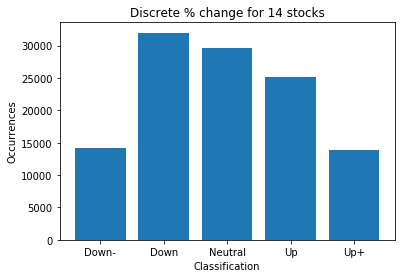

In [99]:
import matplotlib.pyplot as plt

# Distribution of the training data according to categorical price changes.
class_weights = train_df[y_col_name].value_counts().to_dict()
print(class_weights)
print(class_weights[1] / sum(class_weights.values()))

single_guess = [2] * len(experiment_random.y_val)
metrics.accuracy_score(single_guess, y_true)

# Get occurrences, but we want whole number percents. Multiply by 100
occurrences = list(df['3D_pct_change'].apply(lambda x: x*100))


n, bins, patches = plt.hist(occurrences, 1000)
plt.xlim(-10, 10)
plt.xlabel("Percent change over 3 days")
plt.ylabel("Occurrences")
plt.title("Continuous % change for 14 stocks")
#plt.show()
plt.savefig("continuous.png")

plt.clf()

# TODO: Make a graph to show that this is a reasonable categorical representation.
#df_dist = df['3D_pct_change'].value_counts().to_dict()
#print(df_dist)
occurrences_dict = {"Down-" : (df.loc[df['3D_pct_change'] < -0.05]).shape[0], 
            "Down" : (df.loc[(df['3D_pct_change'] >= -0.05) & (df['3D_pct_change'] <= -0.01)]).shape[0],
            "Neutral" : (df.loc[(df['3D_pct_change'] >= -0.01) & (df['3D_pct_change'] <= 0.01)]).shape[0],
            "Up" : (df.loc[(df['3D_pct_change'] >= 0.01) & (df['3D_pct_change'] <= 0.05)]).shape[0],
            "Up+" : (df.loc[df['3D_pct_change'] >= 0.05]).shape[0]}

plt.bar(occurrences_dict.keys(), occurrences_dict.values())
plt.xlabel("Classification")
plt.ylabel("Occurrences")
plt.title("Discrete % change for 14 stocks")
#plt.show()
plt.savefig("discrete.png")